# Fish-Classification-Analysis

# Imports

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,LabelEncoder, PowerTransformer
# Model Selection and Metrics
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# Functions

In [112]:
def check_nulls_dupes(df):
  print(f"The Amount of Null Values: {df.isna().sum()}")
  print(f"The Amount of Duplicated Values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(12, 10))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(15, 10))
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.show()
  
def plot_dataset(df, visual_type):
  
  plt.figure(figsize=(16,16))
  cols = len(df.columns)
  rows = (cols +3)//4
  
  for idx, col in enumerate(df.columns):
    plt.subplot(rows, 3, idx+1)
    plt.title(col)
    sns.histplot(data=df[col], kde=True) if visual_type == "hist" else sns.boxplot(df[col])
    plt.xlabel(col)
  
  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(10,10))

  for idx, col in enumerate(df.columns):
    plt.subplot(3, 3, idx+1)
    sns.histplot(df[col], kde=True) if kind == "Hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")
  plt.tight_layout()
  plt.show()

def find_outliers_isolation_forest(df):
    outlier_df = df.copy()
    iso_forest = IsolationForest(contamination=0.05)  # Adjust contamination level as needed
    for col in outlier_df.columns:
        outlier_df[f'{col}_outlier'] = iso_forest.fit_predict(df[[col]])
    return outlier_df

def create_sklearn_pipeline(model, kbest=None):
  
  steps = [
      ("Scaler", StandardScaler()),
      ("model", model)
    ]
  
  if kbest:
    steps.insert(1, ("Feature-Selection", kbest))
    
  return Pipeline(
    steps = steps
  )

def find_outliers_dbscan(df):
    dbscan = DBSCAN(eps=0.03, min_samples=2)
    pipeline = create_sklearn_pipeline(dbscan)
    pipeline.fit(df)
    dbscan_labels = pipeline.named_steps['model'].labels_
    df['Outlier'] = dbscan_labels
    return df[df['Outlier'] == -1]

def pca_analysis(X):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  print(performance_df)

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(probability=True),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT":CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='macro')
    precision_metric = precision_score(y, predictions, average='macro')
    f1_metric = f1_score(y, predictions, average='macro')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(model, kbest) if kbest else create_sklearn_pipeline( model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

def optimization_search( model_names, models,X, y, optimizer_class, param_distributions, scoring_metric):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker, best_models = [], []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(model)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append({
      "model_name":model_name,
      "model":best_model
    })
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker), best_models

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return metric_tracker


# EDA

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/fish_data.csv")
df

,species,length,weight,w_l_ratio
0,Anabas testudineus,10.66,3.45,0.32
1,Anabas testudineus,6.91,3.27,0.47
2,Anabas testudineus,8.38,3.46,0.41
3,Anabas testudineus,7.57,3.36,0.44
4,Anabas testudineus,10.83,3.38,0.31
...,...,...,...,...
4075,Sillaginopsis panijus,30.56,6.12,0.20
4076,Sillaginopsis panijus,29.66,6.11,0.21
4077,Sillaginopsis panijus,32.81,6.25,0.19
4078,Sillaginopsis panijus,29.78,6.11,0.21


In [4]:
df.describe()

,length,weight,w_l_ratio
count,4080.000000,4080.000000,4080.000000
mean,17.353544,3.739875,0.252782
std,7.114684,1.040365,0.123046
min,6.360000,2.050000,0.080000
25%,11.327500,3.070000,0.170000
50%,17.350000,3.310000,0.190000
75%,22.585000,4.100000,0.340000
max,33.860000,6.290000,0.640000


In [5]:
df.dtypes

species       object
length       float64
weight       float64
w_l_ratio    float64
dtype: object

# Check For Class Imbalance

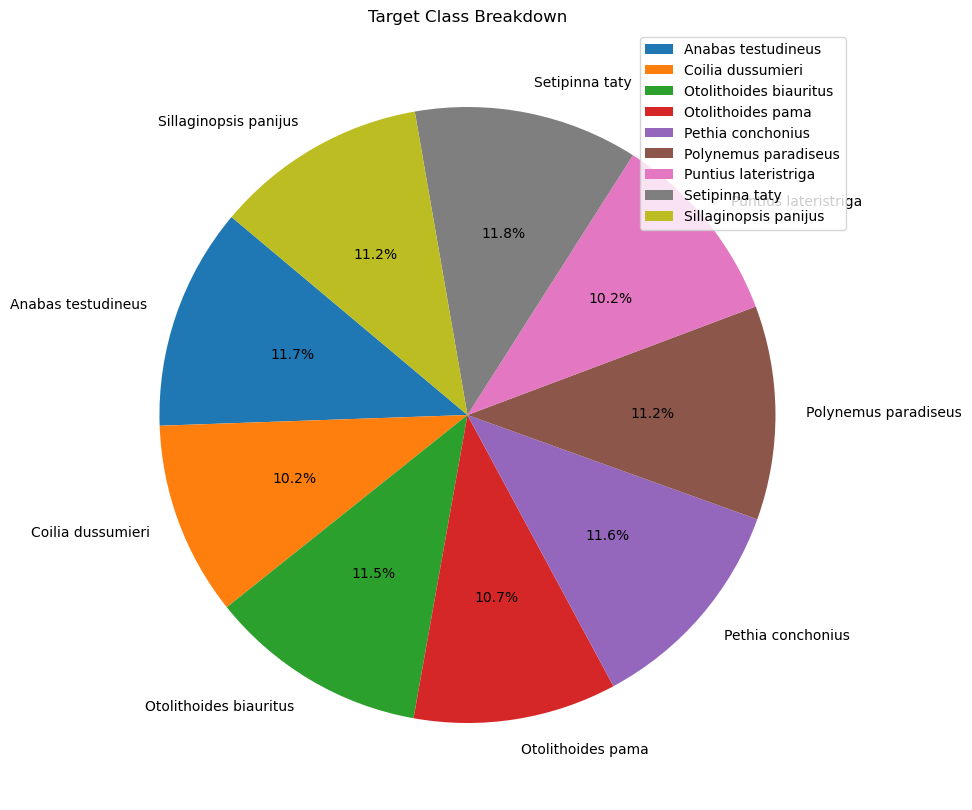

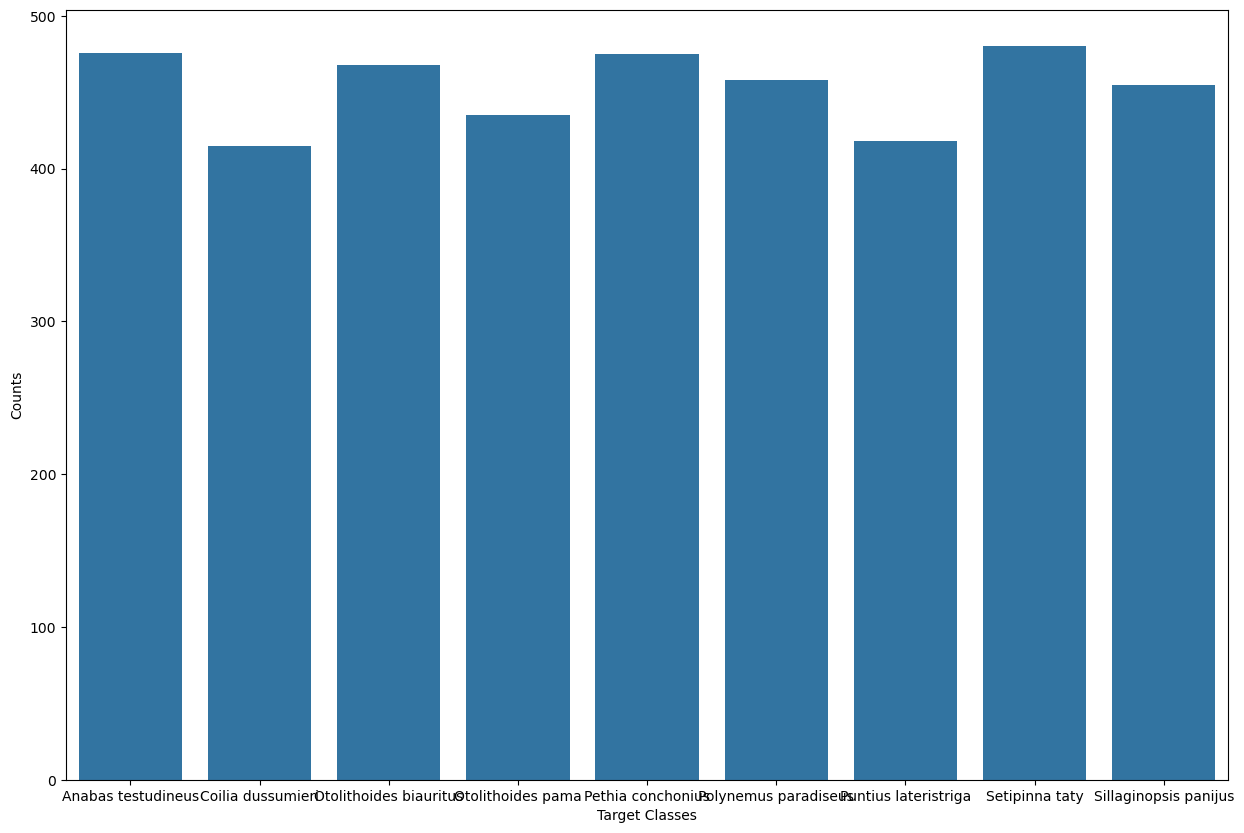

In [6]:
check_class_imbalance(df["species"])

# Check For Nulls and Dupes

In [7]:
check_nulls_dupes(df)

The Amount of Null Values: species      0
length       0
weight       0
w_l_ratio    0
dtype: int64
The Amount of Duplicated Values: 109


In [8]:
df.drop_duplicates(inplace=True)

<AxesSubplot:>

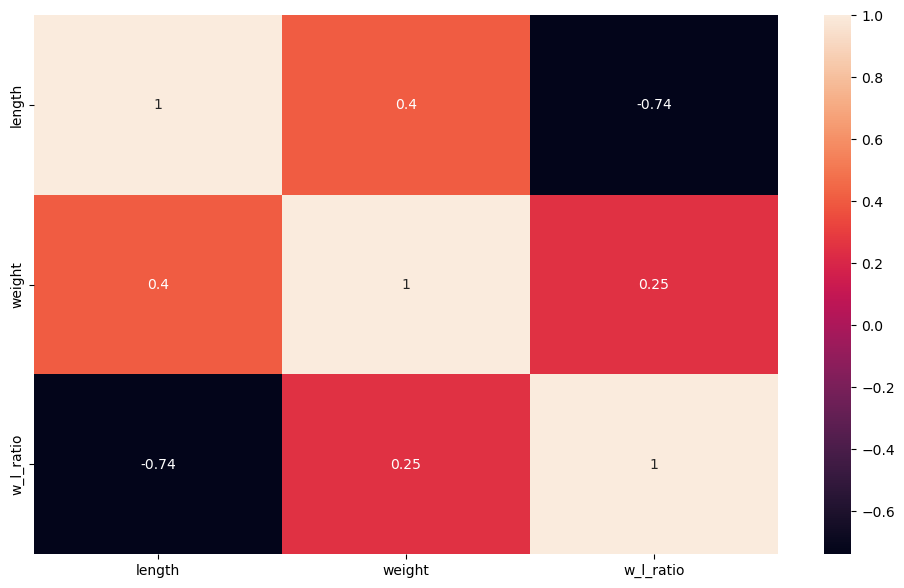

In [9]:
numerical_types = df.select_dtypes(exclude="object")

relations = numerical_types.corr()
plt.figure(figsize=(12, 7))

sns.heatmap(data=relations, annot=True)

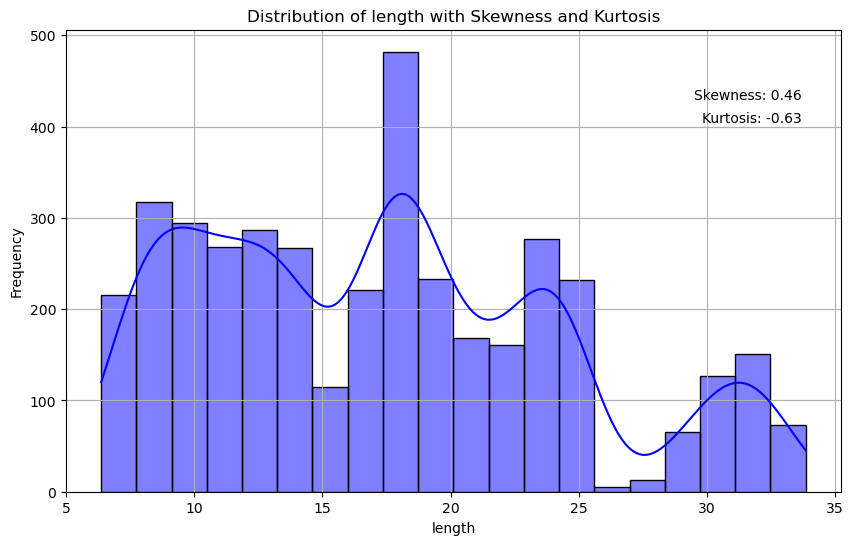

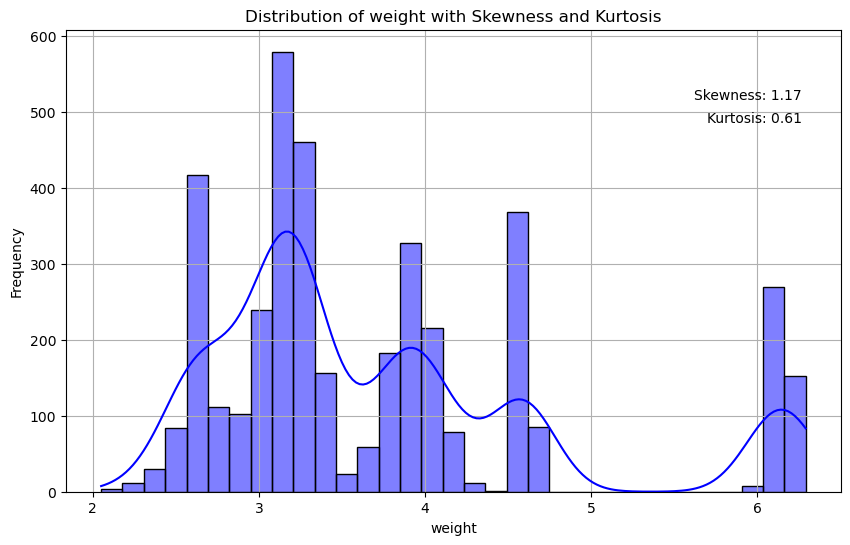

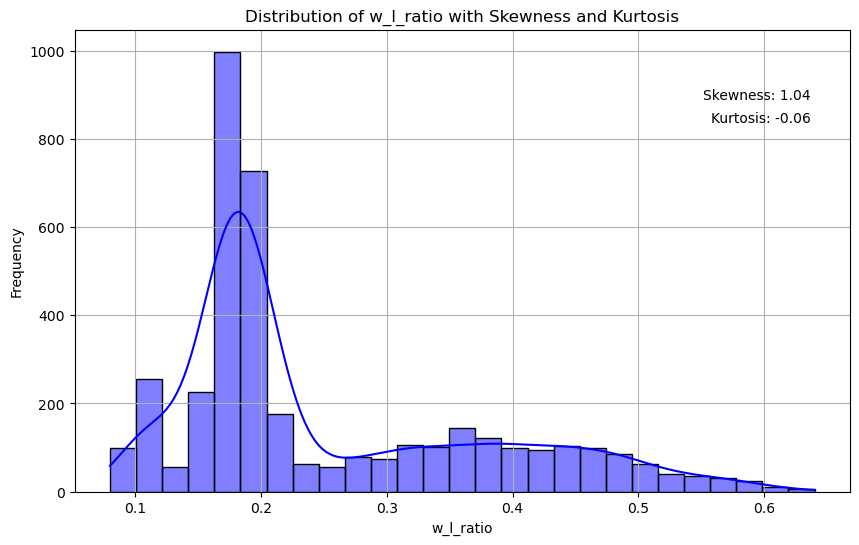

In [10]:
dist_plot(numerical_types)

# Hist and Box Plot

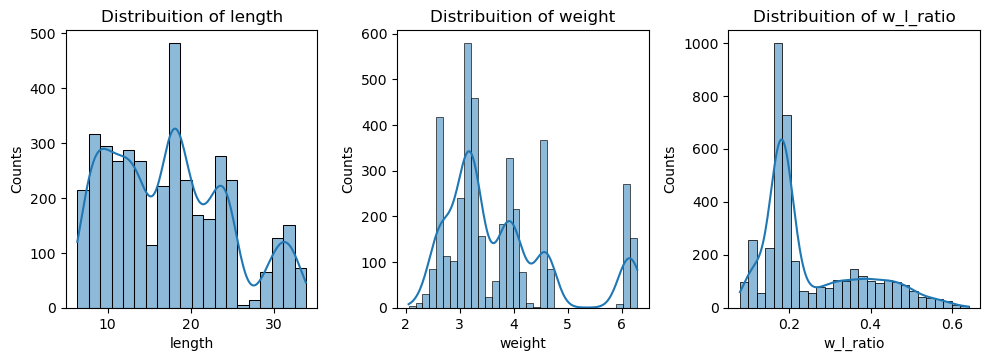

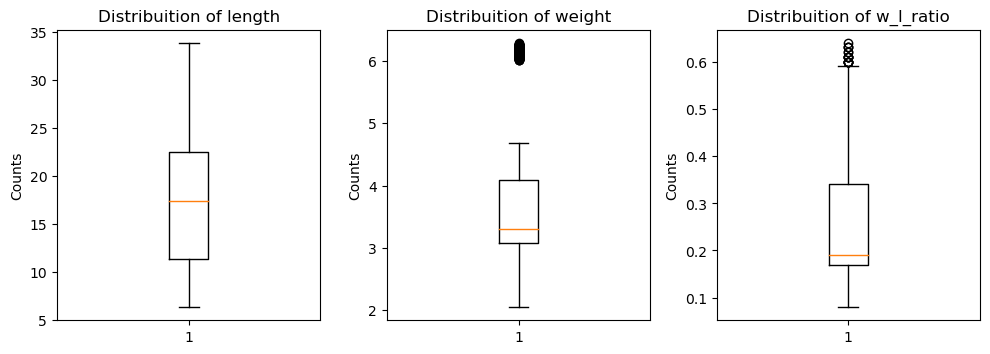

In [30]:
plot_distribution(numerical_types, "Hist")
plot_distribution(numerical_types, "box")

In [31]:
numerical_types.columns

Index(['length', 'weight', 'w_l_ratio'], dtype='object')

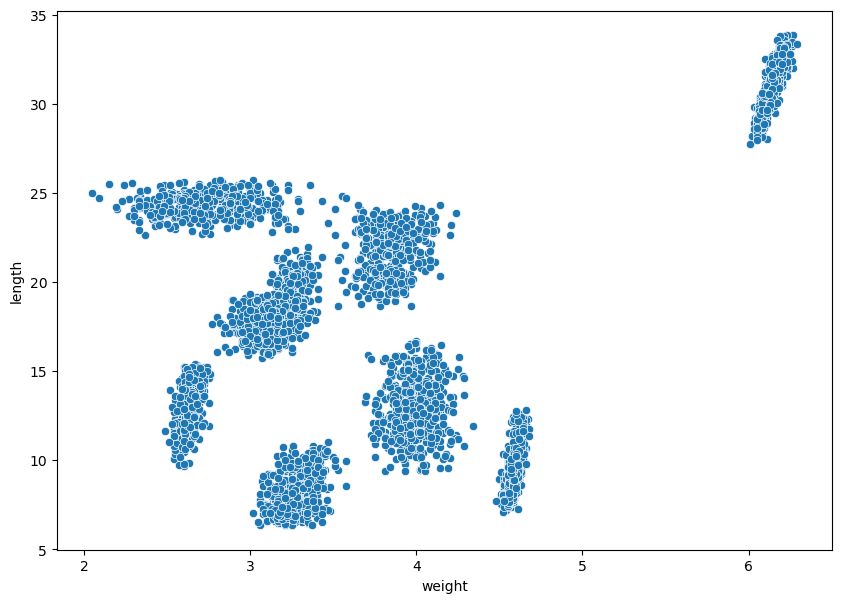

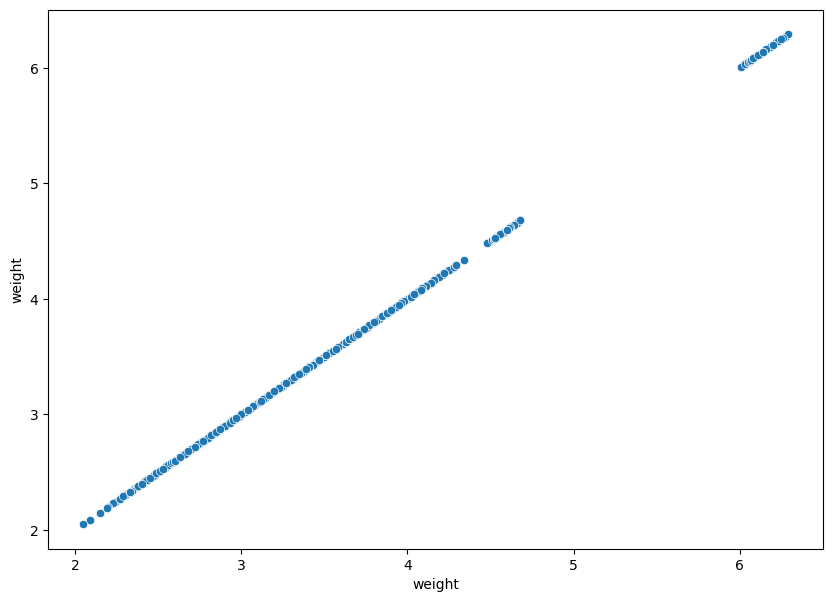

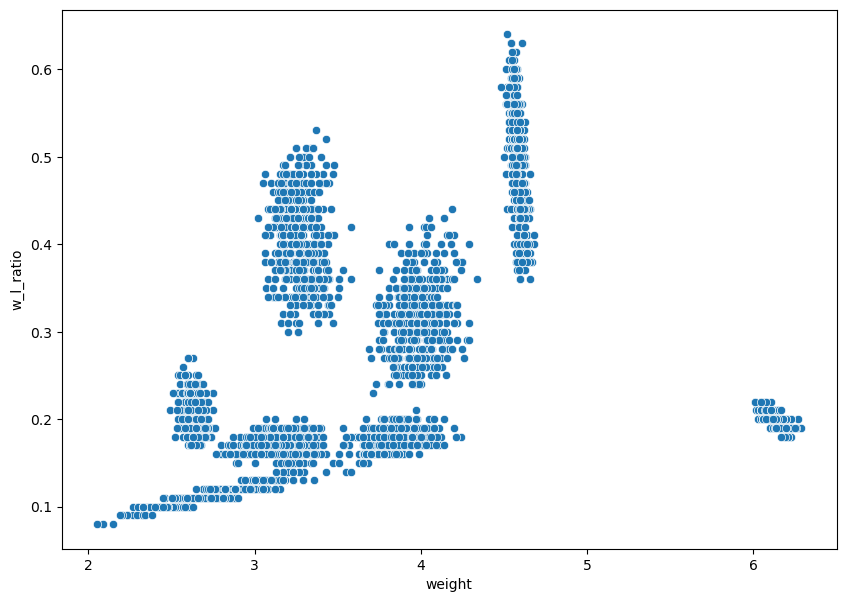

In [33]:
for col in numerical_types.columns:
  plt.figure(figsize=(10, 7))
  sns.scatterplot(data=numerical_types, x="weight", y=col)

In [39]:
species = df["species"].unique()
for col in species:
  eda_df = df[df["species"] == col]
  print(f"{col}")
  print(eda_df.describe())

Anabas testudineus
           length      weight   w_l_ratio
count  462.000000  462.000000  462.000000
mean     8.180736    3.271342    0.406255
std      1.105627    0.101778    0.050572
min      6.360000    3.020000    0.300000
25%      7.280000    3.200000    0.370000
50%      8.030000    3.270000    0.400000
75%      8.950000    3.340000    0.440000
max     11.010000    3.580000    0.530000
Coilia dussumieri
           length      weight   w_l_ratio
count  409.000000  409.000000  409.000000
mean    24.346870    2.748240    0.113007
std      0.644668    0.253774    0.011202
min     22.620000    2.050000    0.080000
25%     23.900000    2.570000    0.110000
50%     24.370000    2.740000    0.110000
75%     24.780000    2.930000    0.120000
max     25.760000    3.580000    0.140000
Otolithoides biauritus
           length      weight   w_l_ratio
count  456.000000  456.000000  456.000000
mean    18.556425    3.198838    0.172961
std      1.283462    0.071331    0.010066
min     15.72000

# Outlier Detection

In [59]:
isolation_outliers = find_outliers_isolation_forest(numerical_types)
dbscan_outliers = find_outliers_dbscan(numerical_types)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [60]:
interested_columns = [col for col in isolation_outliers.columns if "outlier" in col]

for col in interested_columns:
  outlier = isolation_outliers[isolation_outliers["length_outlier"] == -1]
  print(f"{col}\n, {outlier.describe()}")


length_outlier
,            length      weight   w_l_ratio  Outlier  length_outlier  \
count  198.000000  198.000000  198.000000    198.0           198.0   
mean    22.852626    5.149192    0.295404      0.0            -1.0   
std     11.821382    1.388407    0.135944      0.0             0.0   
min      6.360000    3.050000    0.180000      0.0            -1.0   
25%      6.870000    3.290000    0.190000      0.0            -1.0   
50%     28.845000    6.070000    0.210000      0.0            -1.0   
75%     32.727500    6.190000    0.470000      0.0            -1.0   
max     33.860000    6.290000    0.530000      0.0            -1.0   

       weight_outlier  w_l_ratio_outlier  Outlier_outlier  
count      198.000000         198.000000            198.0  
mean         0.262626           0.979798              1.0  
std          0.967344           0.200497              0.0  
min         -1.000000          -1.000000              1.0  
25%         -1.000000           1.000000            

In [61]:
dbscan_outliers

,length,weight,w_l_ratio,Outlier
4,10.83,3.38,0.31,-1
10,8.03,3.40,0.42,-1
11,10.27,3.16,0.31,-1
18,8.85,3.07,0.35,-1
20,10.19,3.24,0.32,-1
...,...,...,...,...
3677,28.06,6.11,0.22,-1
3771,32.01,6.27,0.20,-1
3788,32.55,6.10,0.19,-1
3844,33.57,6.17,0.18,-1


In [62]:
dbscan_outliers.describe()

,length,weight,w_l_ratio,Outlier
count,280.000000,280.000000,280.000000,280.0
mean,16.522357,3.555357,0.254500,-1.0
std,6.331849,0.708182,0.119325,0.0
min,6.390000,2.050000,0.080000,-1.0
25%,10.615000,3.120000,0.167500,-1.0
50%,16.000000,3.510000,0.205000,-1.0
75%,21.830000,3.990000,0.342500,-1.0
max,33.850000,6.270000,0.640000,-1.0


# Split Features

In [63]:
X = df.drop('species', axis=1)
y = df["species"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# PCA Analysis

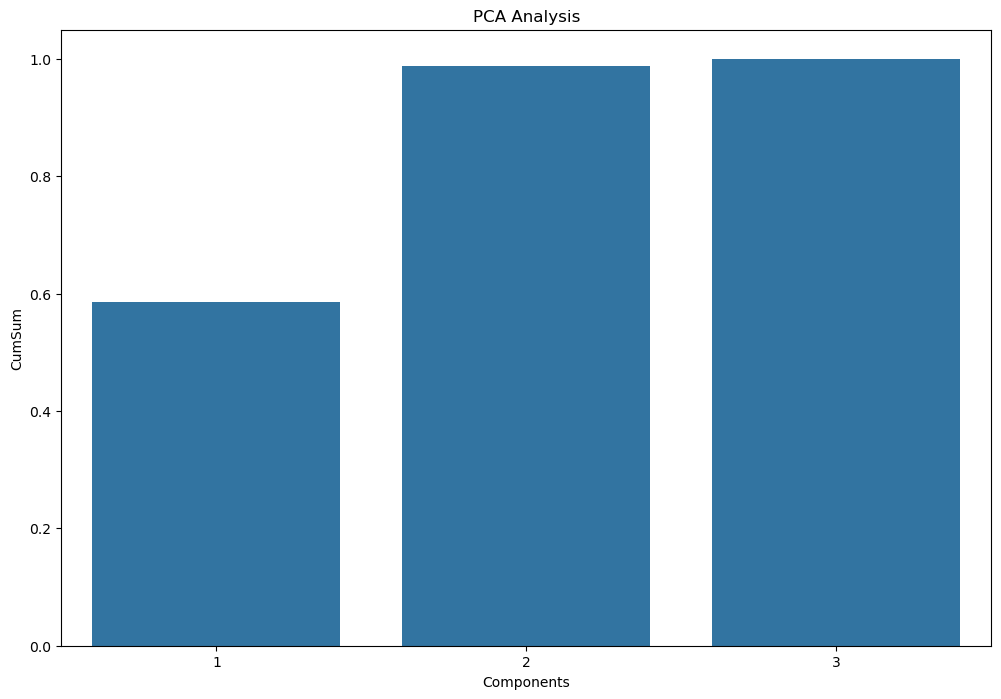

   Component    CumSum
0          1  0.586333
1          2  0.987842
2          3  1.000000


In [64]:
pca_analysis(X)

# Create Metrics

In [65]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="macro")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='macro')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='macro')

# Test Baseline Model

In [68]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(model_name, models, X, y_encoded, acc_metric)

   Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0  DUMMY  0.111  0.0  0.016     0.119         0.119            0.119     0.119


In [71]:
model_names = ["RFC", "XGB", "GBC", "DTC", "LR", "SVC", "KNN", "CAT"]
models = grab_selected_models(model_names)
performance_df = test_selected_models(model_names, models, X, y_encoded, acc_metric)
performance_df

  Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
6   KNN  0.937  0.0  0.011     0.937         0.940            0.940     0.940
2   GBC  0.930  0.0  0.010     0.928         0.932            0.932     0.932
7   CAT  0.929  0.0  0.011     0.931         0.934            0.934     0.934
0   RFC  0.927  0.0  0.010     0.925         0.929            0.929     0.929
5   SVC  0.927  0.0  0.010     0.927         0.931            0.931     0.931
1   XGB  0.925  0.0  0.010     0.922         0.926            0.926     0.926
4    LR  0.925  0.0  0.010     0.925         0.928            0.930     0.928
3   DTC  0.924  0.0  0.011     0.921         0.925            0.925     0.925


# Let's Optimize With Our Best Models

In [79]:
params = {
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'LR': {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga']
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4]
    },
    
    'KNN': {
        'model__n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
        'model__weights': ['uniform', 'distance'],  # Weight function used in prediction
        'model__metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric to use
        'model__p': [1, 2]  # Power parameter for the Minkowski metric
    },
    'CAT': {
        'model__iterations': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__depth': [4, 6, 8],
        'model__l2_leaf_reg': [1, 3, 5]
    }
}

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

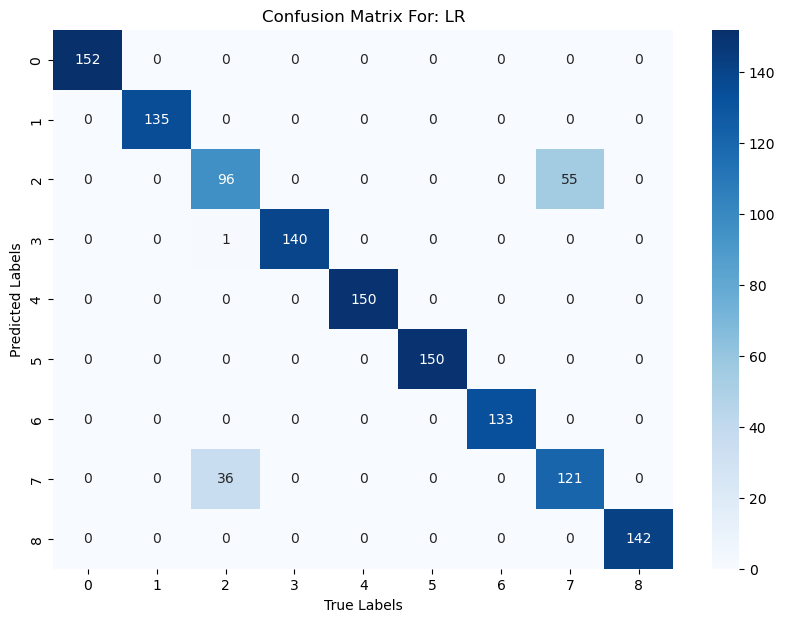

The Best Param: {'model__solver': 'saga', 'model__penalty': 'l1', 'model__C': 10}


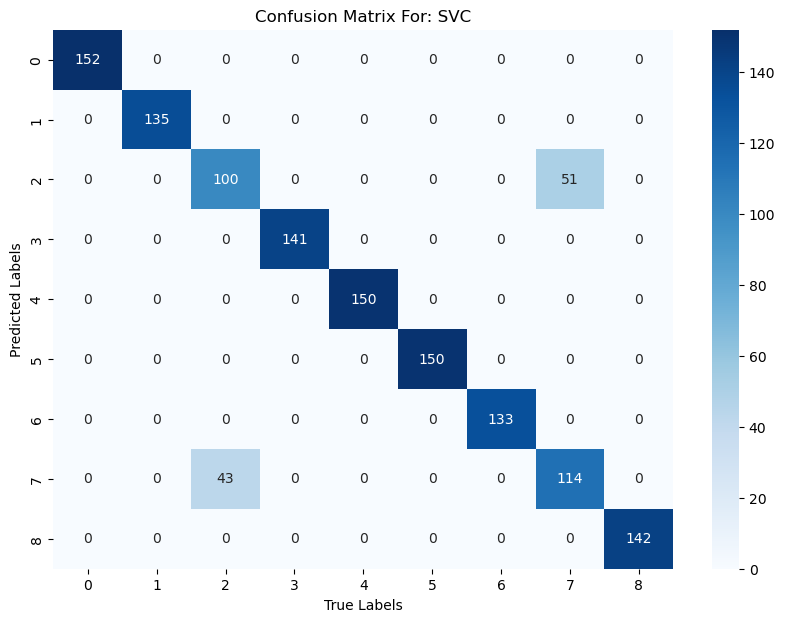

The Best Param: {'model__kernel': 'rbf', 'model__gamma': 'auto', 'model__degree': 2, 'model__C': 10}


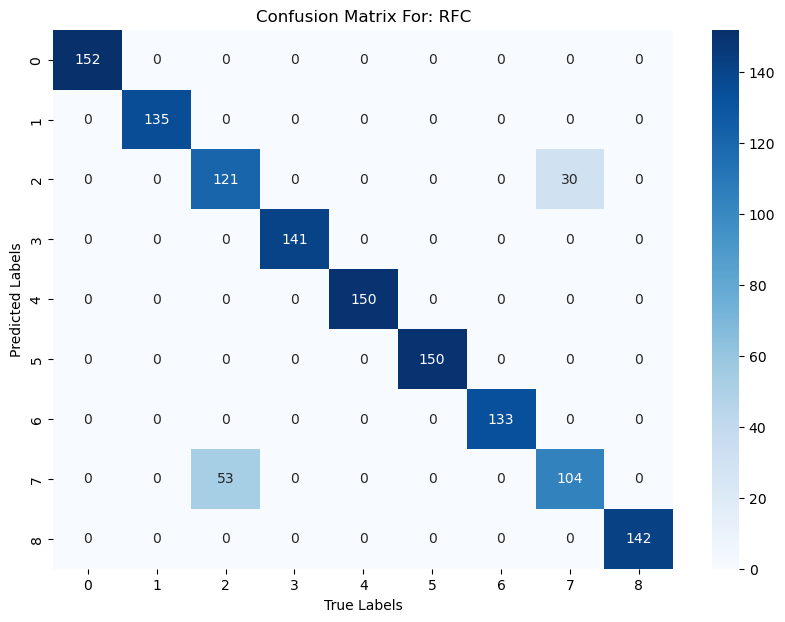

The Best Param: {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': 10}


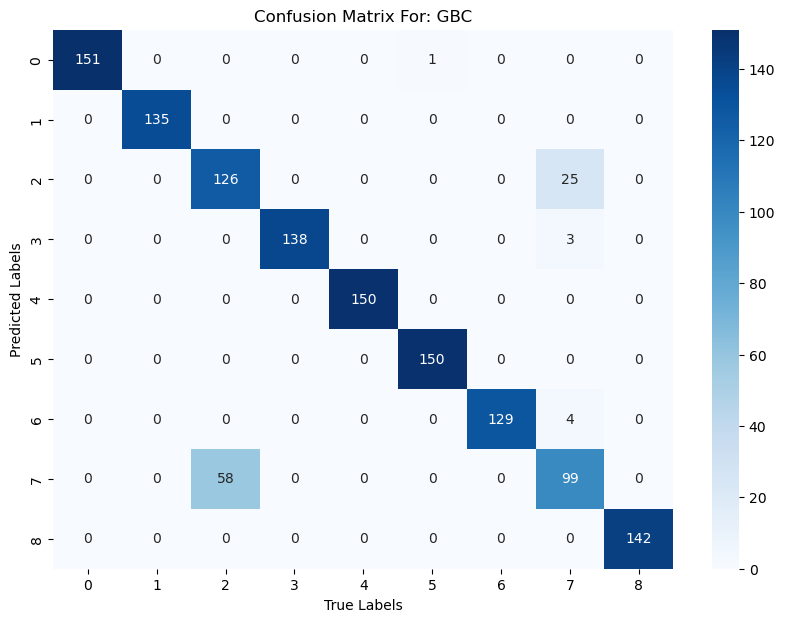

The Best Param: {'model__n_estimators': 100, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 4, 'model__learning_rate': 0.01}


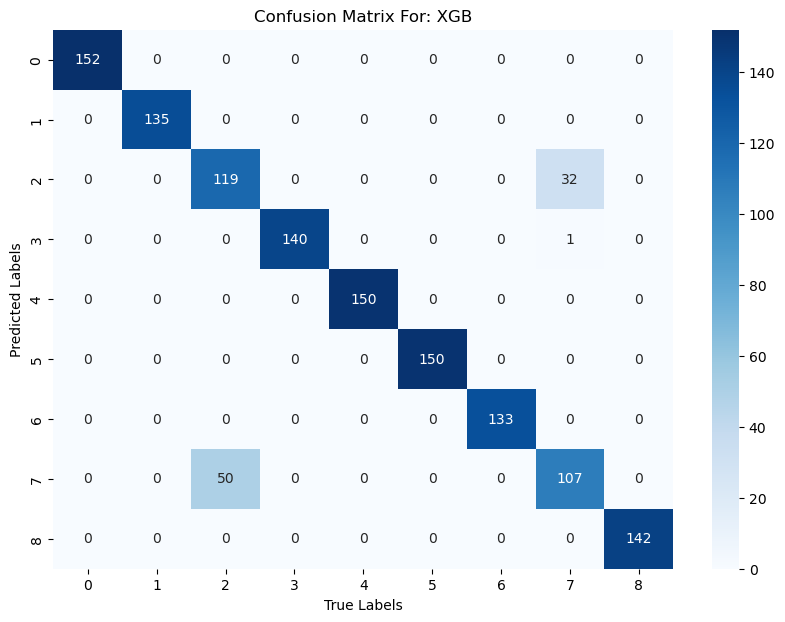

The Best Param: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}


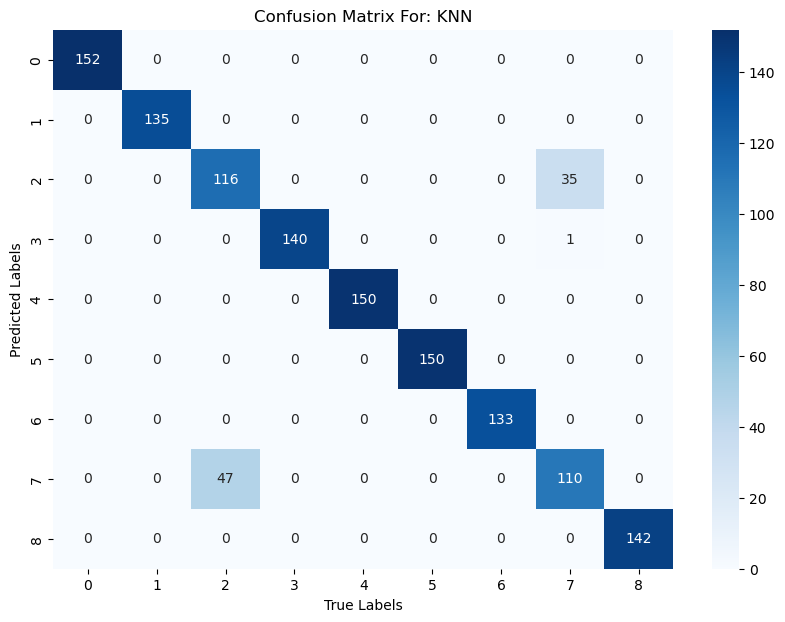

The Best Param: {'model__weights': 'uniform', 'model__p': 2, 'model__n_neighbors': 9, 'model__metric': 'minkowski'}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


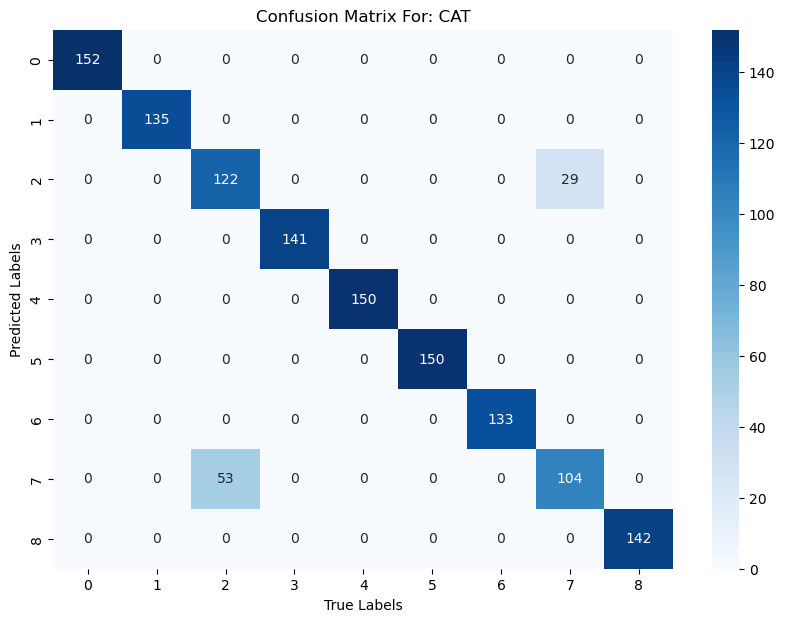

The Best Param: {'model__learning_rate': 0.1, 'model__l2_leaf_reg': 1, 'model__iterations': 100, 'model__depth': 4}
  Model  Test-Acc  F1-Score  recall-Score  precision-Score
6   CAT  0.937452  0.940634      0.941152         0.942122
2   RFC  0.936690  0.939932      0.940416         0.941280
4   XGB  0.936690  0.940081      0.940280         0.940936
5   KNN  0.936690  0.940152      0.940195         0.940565
3   GBC  0.930587  0.934122      0.934120         0.937098
0    LR  0.929825  0.933247      0.933263         0.934367
1   SVC  0.928299  0.932039      0.932041         0.932246


In [102]:
model_names = ["LR", "SVC", "RFC", "GBC", "XGB", "KNN", "CAT"]
models = grab_selected_models(model_names)
performance_df, best_models = optimization_search(model_names, models, X, y_encoded, RandomizedSearchCV, params, acc_metric)
print(performance_df.sort_values(by="Test-Acc", ascending=False))

# Create An Ensemble Method

Testing with models: ['LR']


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


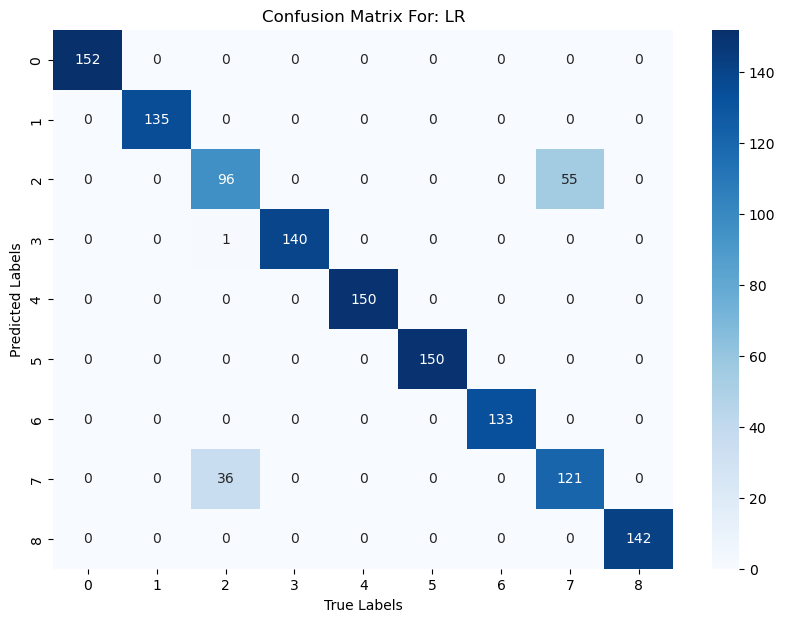

Testing with models: ['LR', 'SVC']


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


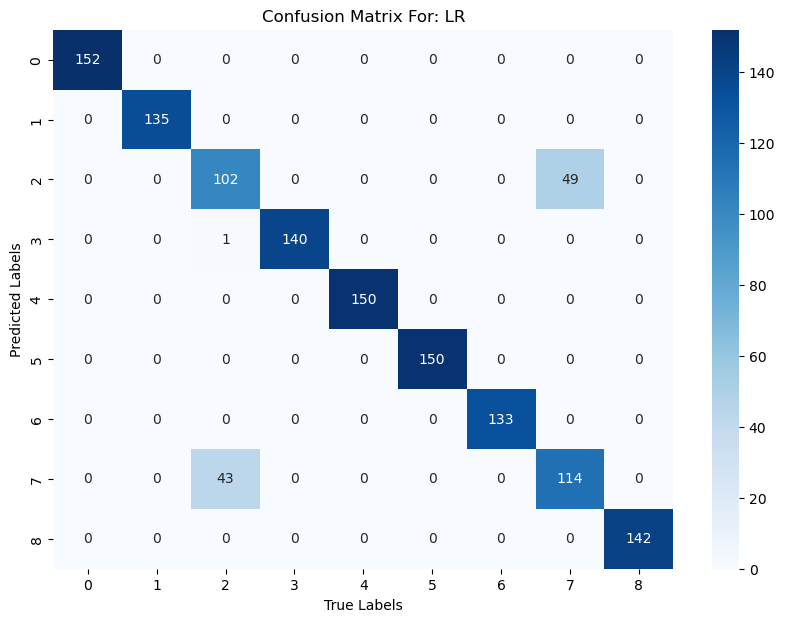

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


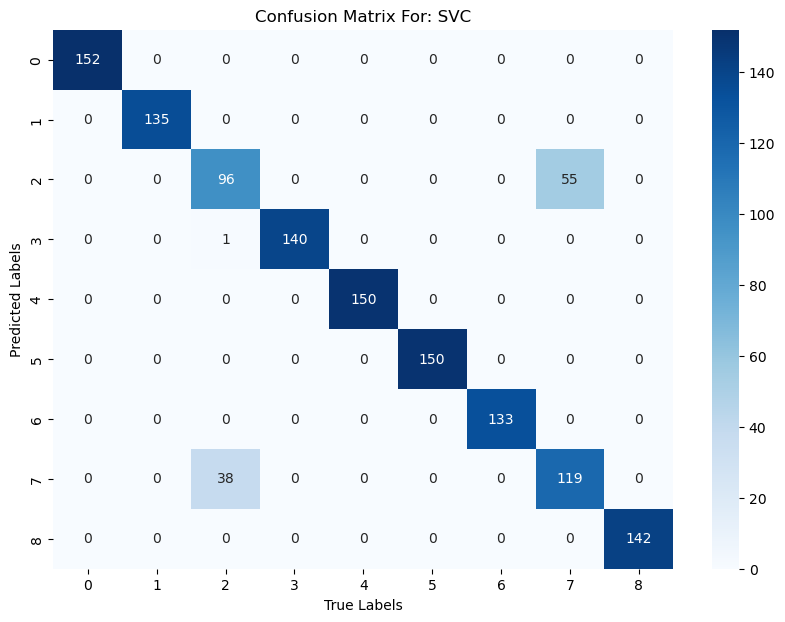

Testing with models: ['LR', 'SVC', 'RFC']


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


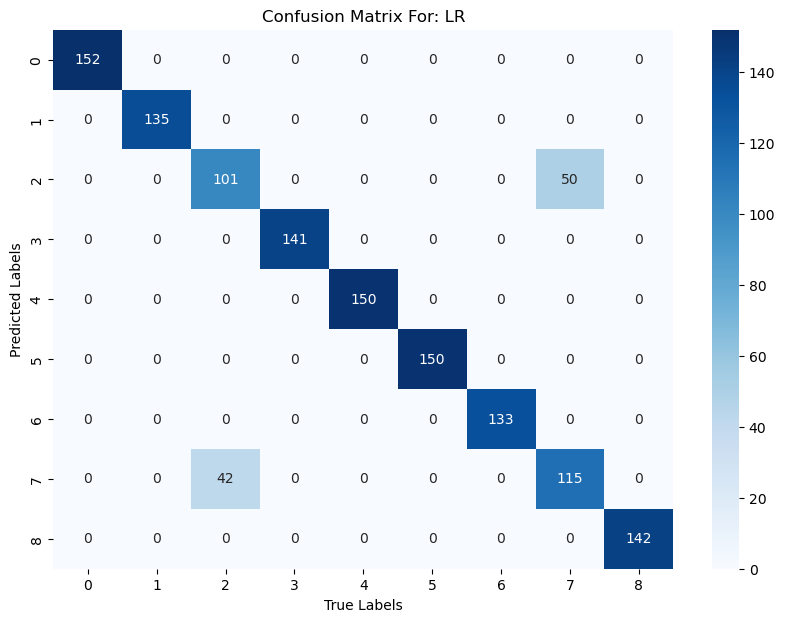

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


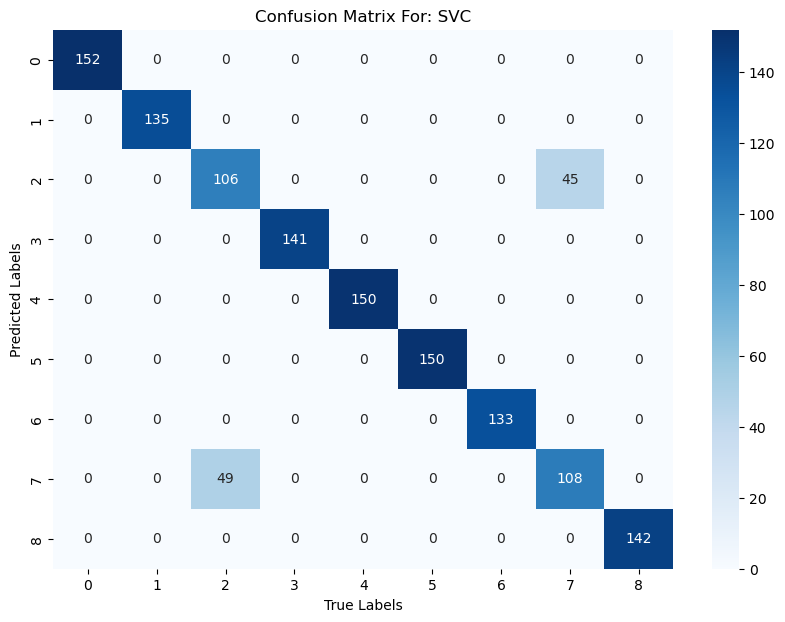

Testing with models: ['LR', 'SVC', 'RFC', 'GBC']


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


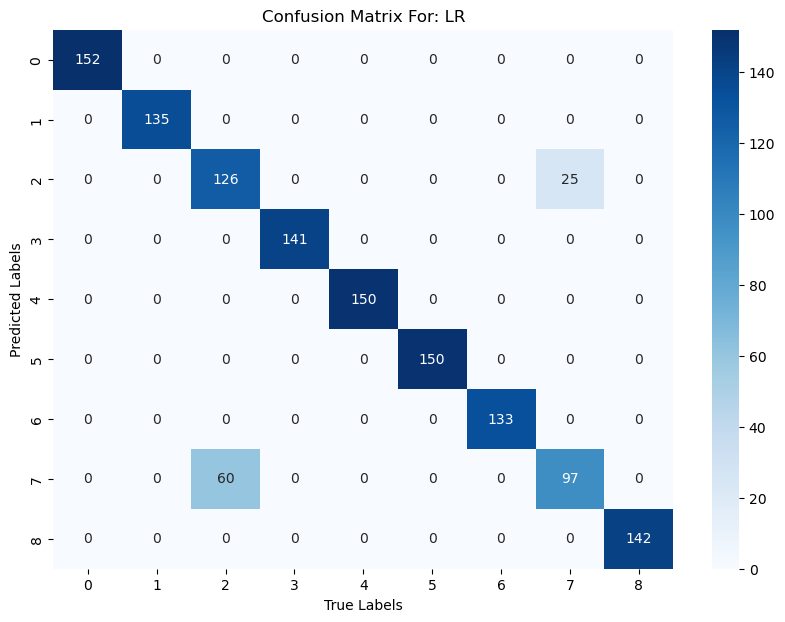

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


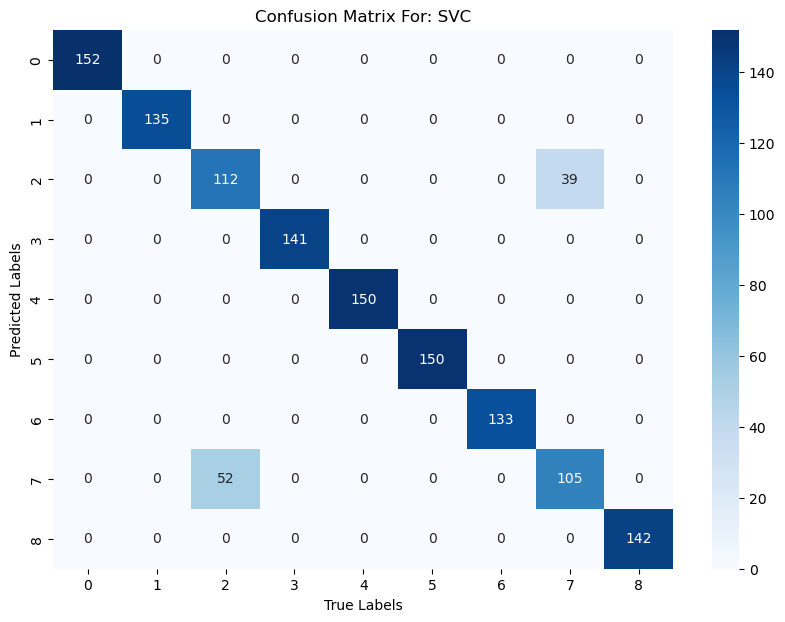

Testing with models: ['LR', 'SVC', 'RFC', 'GBC', 'XGB']


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


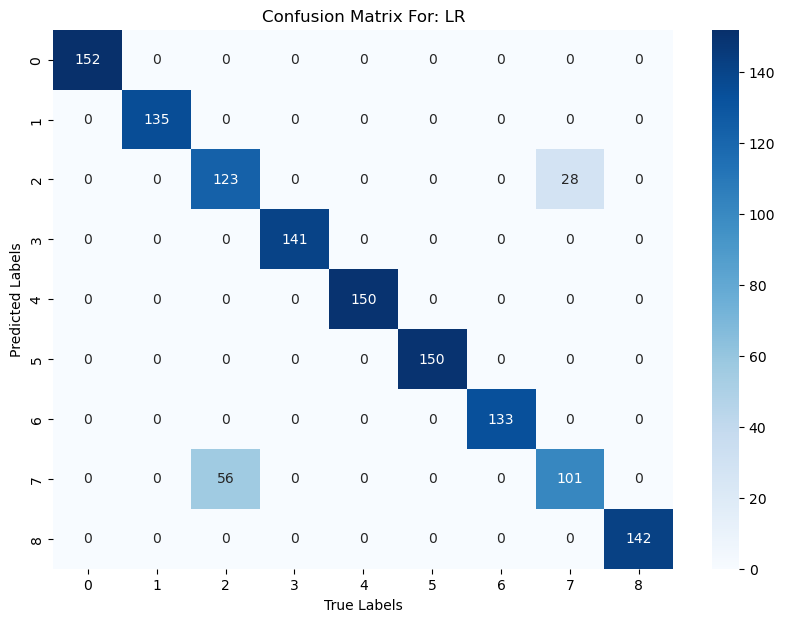

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


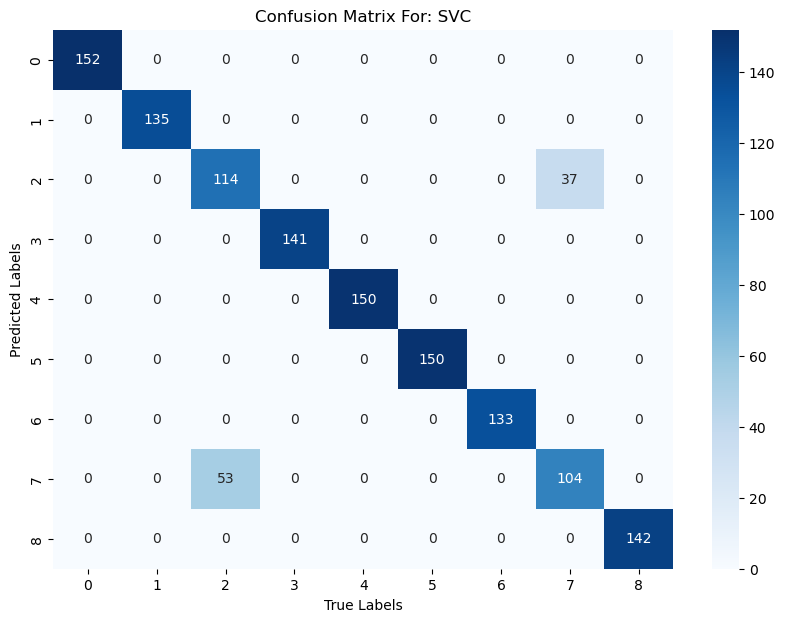

Testing with models: ['LR', 'SVC', 'RFC', 'GBC', 'XGB', 'KNN']


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


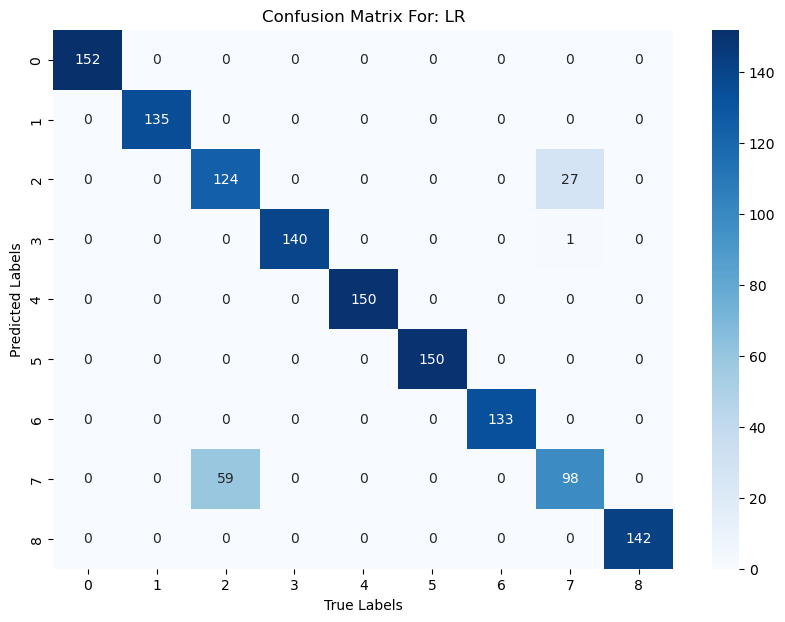

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


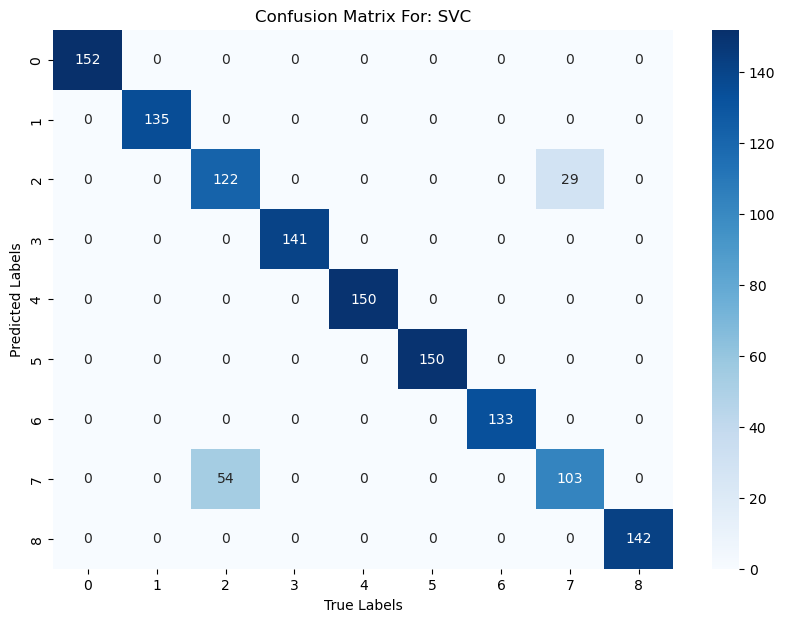

   Model  Test-Acc  F1-Score  recall-Score  precision-Score
10   SVC  0.936690  0.939887      0.940444         0.941498
7     LR  0.935927  0.939083      0.939765         0.941122
5     LR  0.935164  0.938124      0.939141         0.941389
9     LR  0.933638  0.936837      0.937589         0.939486
8    SVC  0.931350  0.934996      0.935265         0.935580
6    SVC  0.930587  0.934310      0.934501         0.934677
0     LR  0.929825  0.933247      0.933263         0.934367
3     LR  0.929825  0.933485      0.933484         0.933696
1     LR  0.929062  0.932868      0.932724         0.933113
2    SVC  0.928299  0.931867      0.931848         0.932780
4    SVC  0.928299  0.932176      0.932209         0.932195


In [113]:

estimators = []
model_names = []
metric_tracker = []


for model in best_models:

  if model["model_name"] == "CAT":
    continue

  estimators.append((model["model_name"], model["model"]))
  model_names.append(model["model_name"])

  voting_hard_clf = VotingClassifier(estimators=estimators, voting="hard")
  voting_soft_clf = VotingClassifier(estimators=estimators, voting="soft")

  print(f"Testing with models: {model_names}")

  current_models = [voting_hard_clf, voting_soft_clf]

  model_metrics = test_stacking_models(X, y_encoded, current_models, model_names)
  
  metric_tracker.extend(model_metrics)
  
print(pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False))
